### Fig 18S probe test (Fig 1)
- 1A: Illustration of the single-probe depletion assay
- 1B: fold depletion for the first 20 probes on targeting the 18S
- 1C: longer probes vs. shorter probes
- 1D: Percent depletion vs. probe Tm

In [3]:
#Imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import os
import gffutils
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib as mpl

sys.path.append('../scripts/')
from plot_helpers import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
#Load results
data_file = '../figures/F1/full_probe_18S_summary.csv'
df = pd.read_csv(data_file).sort_values('probe_num').fillna('none')
df['percent_remaining'] = df['fold_change']*100

In [21]:
#Make outdir and load the data
outdir = '../figures/F1/'
os.makedirs(outdir, exist_ok = True)

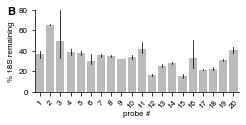

In [22]:
#Fig 1B: Single-probe depletion assay
panel_name = '1B'
plot = Plotter(corners = [0.12, 0.24, 0.855, 0.71], figsize = (sfig*2, sfig))
plot.nudge_corners(bottom = True)
plot.setup_axis()
plot.ax = sns.barplot(x = 'probe_num', y = 'percent_remaining', data = df.loc[df['probe_num'] < 21], 
                 color = selected_colors[0],
                 ax = plot.ax, errwidth = 0.75)
plt.xticks(rotation = 45)
plot.set_ylabel('% 18S remaining')
#plot.set_ylabel('fraction 18S remaining', nudge = (0, -.07))
plot.set_xlabel('probe #')
plot.ax.set_ylim(0, 80)
plot.add_letter('B')

lines = plot.ax.lines
for line in lines:
    line.set_linewidth(0.75)
    line.set_color('k')

plt.savefig(os.path.join(outdir, '{}.png'.format(panel_name)), dpi = 600)

In [9]:
#Report mean depletion value
mean_df = df.groupby(['probe_num', 'length_category', 'tm_category'])[['fold_change', 'percent_remaining']].mean()
mean_depletion_20 = mean_df.loc[1:21, 'fold_change'].mean()
fold_depletion_20 = 1/mean_depletion_20
print('mean dep', mean_depletion_20)
print('fold dep', fold_depletion_20)
mean_df.reset_index(inplace = True)

mean dep 0.3309979898742605
fold dep 3.0211663834571323


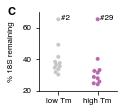

In [10]:
#Fig 1C Performance of high vs. low Tm probes on the left side of the 18S
panel_name = '1C'
#plot = Plotter(corners = [0.24, 0.24, 0.71, 0.71], figsize = (sfig, sfig))
plot = Plotter(corners = [0.27, 0.27, 0.68, 0.68], figsize = (sfig, sfig))

plot.nudge_corners(top = True, right = True)
plot.setup_axis()
plot.ax = sns.swarmplot(x = 'tm_category', y = 'percent_remaining', data = mean_df[mean_df['tm_category'].isin(['low Tm', 'high Tm'])],
                        ax = plot.ax, s = 4, alpha = 0.8)

probe2_av = mean_df[mean_df['probe_num'] == 2]['percent_remaining']
probe29_av = mean_df[mean_df['probe_num'] == 29]['percent_remaining']
plt.text(0 + 0.07, probe2_av - 0.05, '#2', fontsize= 8, ha = 'left')
plt.text(1 + 0.07, probe29_av - 0.05, '#29', fontsize= 8, ha = 'left')
plot.set_ylabel('% 18S remaining')
plot.ax.set_ylim(20, 70)

plot.set_xlabel('')
plot.add_letter('C')

plt.savefig(os.path.join(outdir, '{}.png'.format(panel_name)), dpi = 600)

In [11]:
print('low tm median', 1/mean_df.loc[mean_df['tm_category'] == 'low Tm', 'fold_change'].median())
print('high tm median', 1/mean_df.loc[mean_df['tm_category'] == 'high Tm', 'fold_change'].median())

low tm median 2.736790728971098
high tm median 3.320056470194191


In [12]:
#Calculate the p-value for comparison of low Tm to high Tm probes
#Better to test the ddCt values because the fold changes have been exponentiated
hi_ddCt_means = df[df['tm_category'] == 'high Tm'].groupby('probe_num')['ddCt'].mean().values
low_ddCt_means = df[df['tm_category'] == 'low Tm'].groupby('probe_num')['ddCt'].mean().values
#https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ttest_ind.html
tmean, pmean = stats.ttest_ind(hi_ddCt_means, low_ddCt_means)

print('tmean', tmean)
print('pmean', pmean)

tmean 1.632817051052925
pmean 0.11897005534633223


In [13]:
#What happens if probe 2 and probe 29 are excluded due to being outliers?
hi_ddCt_means_no29 = df[(df['tm_category'] == 'high Tm') & (df['sample'] != 'B29')].groupby('sample')['ddCt'].mean().values
low_ddCt_means_no2 = df[(df['tm_category'] == 'low Tm') & (df['sample'] != 'B2')].groupby('sample')['ddCt'].mean().values

tmean, pmean = stats.ttest_ind(hi_ddCt_means_no29, low_ddCt_means_no2)

print('tmean', tmean)
print('pmean', pmean)

tmean 3.18758231747776
pmean 0.0053896214795932365


In [14]:
#short 30mer vs. longer 50mer probes:
#perform on the first 20 probes because this is the point at which it was evaluated
short_ddCt_means = df[(df['length_category'] == '~30mer') & (df['probe_num'] < 21)].groupby('probe_num')['ddCt'].mean().values
long_ddCt_means = df[df['length_category'] == '~50mer'].groupby('probe_num')['ddCt'].mean().values
#https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ttest_ind.html
tmean, pmean = stats.ttest_ind(short_ddCt_means, long_ddCt_means)

print('tmean', tmean)
print('pmean', pmean)

tmean -0.8898496594854463
pmean 0.3827600401747878


In [15]:
#load properties of probes
prop_file = '../figures/F1/TableS1_18S_candidate_properties.csv'
prop_df = pd.read_csv(prop_file)
prop_df['mean_percent_remaining'] = prop_df['mean_frac_remaining']*100

/Users/maryk.thompson/miniconda3/envs/plotting/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


0.013698440318377024


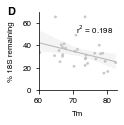

In [23]:
#Fig 1D: Plot efficacy vs. Tm
panel_name = '1D'
plot = Plotter(corners = [0.27, 0.27, 0.68, 0.68], figsize = (sfig, sfig))
plot.nudge_corners(top = True, left = True)
plot.setup_axis()

to_plot_CDE = ['homodimer_dG', 'hairpin_dG', 'Tm']
x_label_dict = {'homodimer_dG': r'homodimer $\Delta$G', 'hairpin_dG': r'hairpin $\Delta$G', 'Tm': 'Tm'}
s_df = prop_df.loc[prop_df['probe_num'] < 31].copy()
plot.ax = sns.regplot(x = 'Tm', y = 'mean_percent_remaining', data = s_df, scatter_kws = {'edgecolors': 'none', 's': 8}, ax = plot.ax)
r_value = stats.spearmanr(s_df['Tm'], s_df['mean_percent_remaining'])

r_squared = r_value[0]**2
p_value = r_value[1]

plot.set_ylabel('% 18S remaining')
plot.set_xlabel('Tm')
plot.ax.set_xlim(60, 83)
plot.ax.set_ylim(0, 70)
plot.add_letter('D')

plot.ax.annotate('r'r'$^2$'' = %1.3f' % r_squared, xy=(0.95, 0.85), annotation_clip=False, xytext=None, 
            textcoords='axes fraction',fontsize = 8, arrowprops=None, ha = 'right', va = 'top')
print(p_value)

plt.savefig(os.path.join(outdir, '{}.png'.format(panel_name)), dpi = 600)